In [6]:
using Pkg; Pkg.add("ControlSystemIdentification"); Pkg.add("Plots")

In this notebook, we will explore transfer-function estimation by means of good old least-squares (and its beefier cousin total least-squares) using [ControlSystemIdentification.jl](https://github.com/baggepinnen/ControlSystemIdentification.jl)
Before any identification can begin, we need to load all the relevant packages.

In [1]:
using ControlSystemIdentification, ControlSystems, Plots
using Random, LinearAlgebra
default(size=(500,280))

We start by creating a system to use as the subject of identification and some data to use for identification

In [3]:
N  = 500      # Number of time steps
t  = 1:N
Δt = 1        # Sample time
u  = randn(1, N) # A random control input
G  = tf(0.8, [1,-0.9], 1) # An interesting system
sim(sys,u) = lsim(sys, u, t)[1][:]
y  = sim(G,u)
yn = y + randn(size(y));

# Validation data
uv  = randn(1, N)
yv  = sim(G,uv)
ynv = yv + randn(size(yv));

ARX stands for autoregressive with external input. An arx model is almost never that great, but it is very easy to fit, so we often use it anyways. The reason it's not that great is that it models the data as
$$A(q)y = B(q) + e$$
where $y$ is the output, $u$ input and $e$ some random stuff. Unfortunately, most data is subject to measurement noise, i.e., a model on the output-error form
$$y = \dfrac{B(q)}{A(q)} + e$$
or perhaps the Box-Jenkins form
$$y = \dfrac{B(q)}{A(q)} + \dfrac{C(q)}{D(q)}e$$
would be more suitable. These two models are a bit trickier to fit though, so for now, we stick to the ARX model. If you want fancier models, check out the notebook `identification_statespace`.

We define the number of coefficients in our $A$ and $B$ polynomials, and then estimate a model

In [4]:
na,nb = 1,1   # Number of polynomial coefficients to estimate
d = iddata(yn,u,Δt)
Gls = arx(d,na,nb)

TransferFunction{Discrete{Int64}, ControlSystems.SisoRational{Float64}}
  0.8048839441473892
-----------------------
1.0z - 0.62796561295456

Sample Time: 1 (seconds)
Discrete-time transfer function model

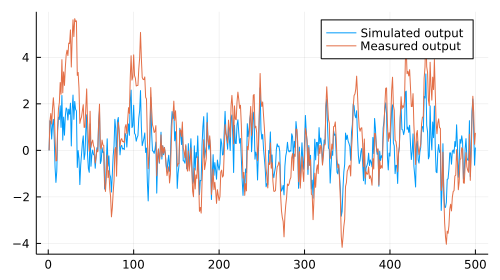

In [5]:
plot([sim(Gls,uv) yv], lab=["Simulated output" "Measured output"])

That didn't do too well. The coefficients are far from the correct values and the simulation performance is bad.

We now explore slightly more advanced alternatives

In [6]:
na,nb,nc = 1,1,1

Gls      = arx(d,na,nb)                      # Regular least-squares estimation
Gtls     = arx(d,na,nb, estimator=tls)       # Total least-squares estimation
Gwtls    = arx(d,na,nb, estimator=wtls_estimator(y,na,nb)) # Weighted Total least-squares estimation
Gplr, Gn = plr(d,na,nb,nc, initial_order=20) # Pseudo-linear regression
@show Gls; @show  Gtls; @show  Gwtls; @show  Gplr;

Gls = TransferFunction{Discrete{Int64}, ControlSystems.SisoRational{Float64}}
  0.8048839441473892
-----------------------
1.0z - 0.62796561295456

Sample Time: 1 (seconds)
Discrete-time transfer function model
Gtls = TransferFunction{Discrete{Int64}, ControlSystems.SisoRational{Float64}}
   1.965565290851144
------------------------
1.0z - 0.752251342057395

Sample Time: 1 (seconds)
Discrete-time transfer function model
Gwtls = TransferFunction{Discrete{Int64}, ControlSystems.SisoRational{Float64}}
   0.8160844069315676
-------------------------
1.0z - 0.8859763690852146

Sample Time: 1 (seconds)
Discrete-time transfer function model
Gplr = TransferFunction{Discrete{Int64}, ControlSystems.SisoRational{Float64}}
   0.8065816884894488
-------------------------
1.0z - 0.8691925345440983

Sample Time: 1 (seconds)
Discrete-time transfer function model


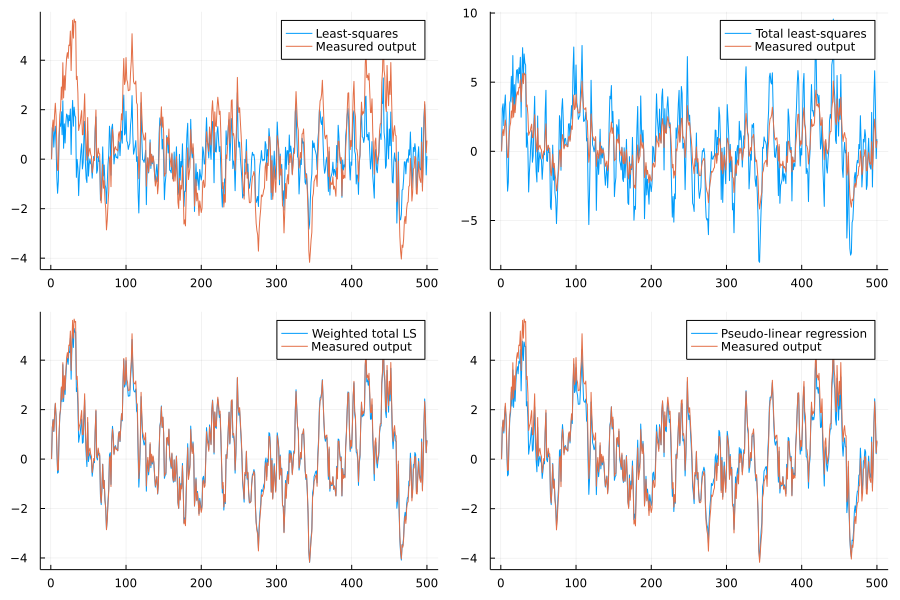

In [7]:
plot([sim(Gls,uv) sim(Gtls,uv) sim(Gwtls,uv) sim(Gplr,uv)  yv yv yv yv],
    lab=["Least-squares" "Total least-squares" "Weighted total LS" "Pseudo-linear regression" fill("Measured output",1,4)],
    layout = 4,
    size   = (900,600))

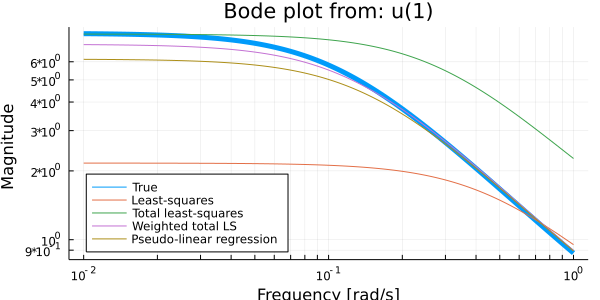

In [8]:
bodeplot([G, Gls, Gtls, Gwtls, Gplr], exp10.(LinRange(-2,log10(Δt),150))
                                    , lab=["True" "Least-squares" "Total least-squares" "Weighted total LS" "Pseudo-linear regression"]
                                    , linewidth = [5 1 1 1 1]
                                    , plotphase = false
                                    , legend    = :bottomleft
                                    , size      = (600,300))

Both simulation results and the bode diagrams indicate that the weighted total least-squares approach did best. Pseudo-linear regression does almost as good, while estimating also a primitive noise model. The reason ordinary LS does so poorly is due to feedback of measurement noise, causing a bias in the estimate. TLS does poorly, probably because not all regressors have the same variance (there is no variance in $u$). WTLS does really well, but using it properly requries providing the WTLS algorithm with the proper covariance matrices. The code `estimator=wtls_estimator(y,na,nb)` creates an estimator function that uses isotropic covariance for all $y$-regressors and zero variance for $u$.